In [26]:
# Core packages
import os
import time
from datetime import datetime, timedelta

# Data manipulation
import numpy as np
import pandas as pd

# Data sources
import yfinance as yf
import json

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Plot settings
%matplotlib inline
sns.set(rc={"figure.figsize": (12, 6)})

# ML / Stats (optional depending on modeling needs)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report


# Paths
RAW_DATA_DIR = "../data/raw/"
PROCESSED_DATA_DIR = "../data/processed/"
PLOTS_DIR = "../plots/"

In [27]:
#load ticker metadata
with open("../ticker_info.json", "r") as f:
    ticker_info = json.load(f)

# Load cleaned data
file_path = f"{PROCESSED_DATA_DIR}multi_asset_5yr_data_cleaned.csv"
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

# Confirm structure
print(df.shape)
print(df.columns)
df.head()

(1826, 35)
Index(['Close_AAPL', 'Close_BTC-USD', 'Close_EPD', 'Close_GOOGL', 'Close_MSFT',
       'Close_TLT', 'Close_XLE', 'High_AAPL', 'High_BTC-USD', 'High_EPD',
       'High_GOOGL', 'High_MSFT', 'High_TLT', 'High_XLE', 'Low_AAPL',
       'Low_BTC-USD', 'Low_EPD', 'Low_GOOGL', 'Low_MSFT', 'Low_TLT', 'Low_XLE',
       'Open_AAPL', 'Open_BTC-USD', 'Open_EPD', 'Open_GOOGL', 'Open_MSFT',
       'Open_TLT', 'Open_XLE', 'Volume_AAPL', 'Volume_BTC-USD', 'Volume_EPD',
       'Volume_GOOGL', 'Volume_MSFT', 'Volume_TLT', 'Volume_XLE'],
      dtype='object')


,Close_AAPL,Close_BTC-USD,Close_EPD,Close_GOOGL,Close_MSFT,Close_TLT,Close_XLE,High_AAPL,High_BTC-USD,High_EPD,...,Open_MSFT,Open_TLT,Open_XLE,Volume_AAPL,Volume_BTC-USD,Volume_EPD,Volume_GOOGL,Volume_MSFT,Volume_TLT,Volume_XLE
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-07,NaN,11601.472656,NaN,NaN,NaN,NaN,NaN,NaN,11898.038086,NaN,...,NaN,NaN,NaN,NaN,2.313231e+10,NaN,NaN,NaN,NaN,NaN
2020-08-08,NaN,11754.045898,NaN,NaN,NaN,NaN,NaN,NaN,11800.064453,NaN,...,NaN,NaN,NaN,NaN,1.757206e+10,NaN,NaN,NaN,NaN,NaN
2020-08-09,NaN,11675.739258,NaN,NaN,NaN,NaN,NaN,NaN,11806.056641,NaN,...,NaN,NaN,NaN,NaN,1.748961e+10,NaN,NaN,NaN,NaN,NaN
2020-08-10,109.776489,11878.111328,12.533845,74.394829,199.521301,146.511841,31.332096,110.796568,12045.140625,12.615990,...,202.797952,147.464797,30.620930,212403600.0,2.611411e+10,6863700.0,20546000.0,36716500.0,6408500.0,26308100.0
2020-08-11,106.511749,11410.525391,12.451701,73.585693,194.855453,144.770477,31.225826,109.537898,11932.710938,12.848732,...,198.477016,144.822454,31.945166,187902400.0,2.703978e+10,7558200.0,31098000.0,36446500.0,19234200.0,26513100.0


In [29]:
#use dictionary to filter by type
def get_asset_subset(df, ticker_info, asset_type="equity", price_type="Close"):
    tickers = [k for k, v in ticker_info.items() if v["type"] == asset_type]
    cols = [f"{price_type}_{t}" for t in tickers]
    subset = df[cols]
    
    #Rename columns: "CLOSE_AAPL" --> "AAPL"
    subset.columns = [col.split("_")[-1] for col in subset.columns]

    return subset

#create filters for stock type
df_close_equity = get_asset_subset(df, ticker_info, asset_type="equity")
df_close_etf = get_asset_subset(df, ticker_info, asset_type="etf")
df_close_crypto = get_asset_subset(df, ticker_info, asset_type="crypto")

print(df_close_equity.columns)
print(df_close_etf.columns)
print(df_close_crypto.columns)


Index(['AAPL', 'MSFT', 'GOOGL', 'EPD'], dtype='object')
Index(['TLT', 'XLE'], dtype='object')
Index(['BTC-USD'], dtype='object')


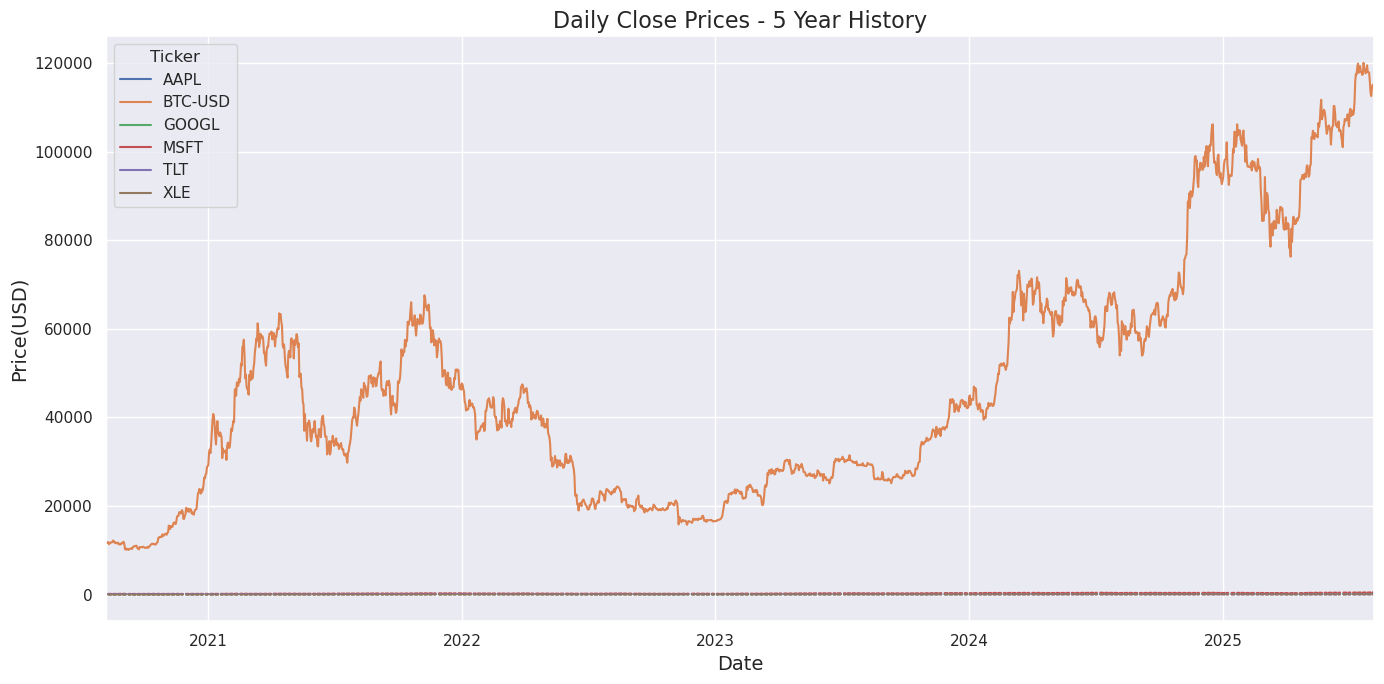

In [ ]:
#plot
df_close.plot(figsize=(14,7))
plt.title('Daily Close Prices - 5 Year History', fontsize=16)
plt.ylabel("Price(USD)", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.grid(True)
plt.legend(title="Ticker")
plt.tight_layout()
plt.show()

/tmp/ipykernel_21158/1611503647.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = df_close.pct_change().dropna()


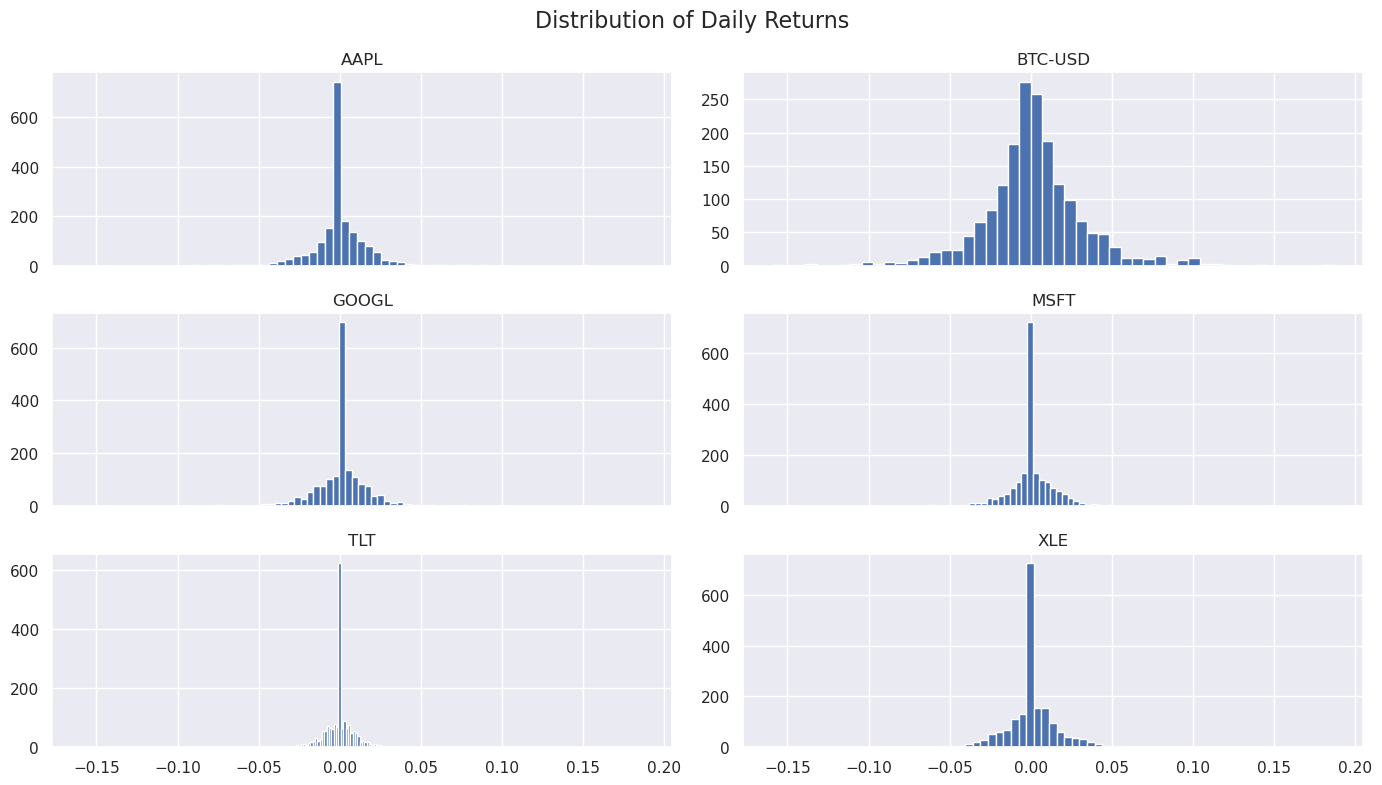

In [7]:
#Daily Returns Distribution (Per Asset)
daily_returns = df_close.pct_change().dropna()
daily_returns.hist(bins=50, figsize=(14,8), sharex=True)
plt.suptitle("Distribution of Daily Returns", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
#correlation Heatmap

sns.heatmap(daily_returns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Daily Returns", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
#Rolling Volatility
volatility = daily_returns.rolling(window=30).std()
volatility.plot(figsize=(14,6))
plt.title("30-Day Rolling Volatility", fontsize=16)
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [ ]:
#Cumulative Returns
cumulative_returns = (1 + daily_returns).cumprod()
cumulative_returns.plot(figsize=(14,7))
plt.title("Cumulative Returns",fontsize=16)
plt.ylabel("Growth of $1 Investment")
plt.xlabel("Date")
plt.grid(True)
plt.legent(title="Ticker")
plt.tight_layout()
plt.show()

In [ ]:
#Sharpe Ratio 
#assume risk-free rate is 0 for simplicity
sharpe_ratios = daily_returns.mean()/daily_returns.std()
print("Sharpe Ratios:\n", sharpe_ratios.sort_values(ascending=False))